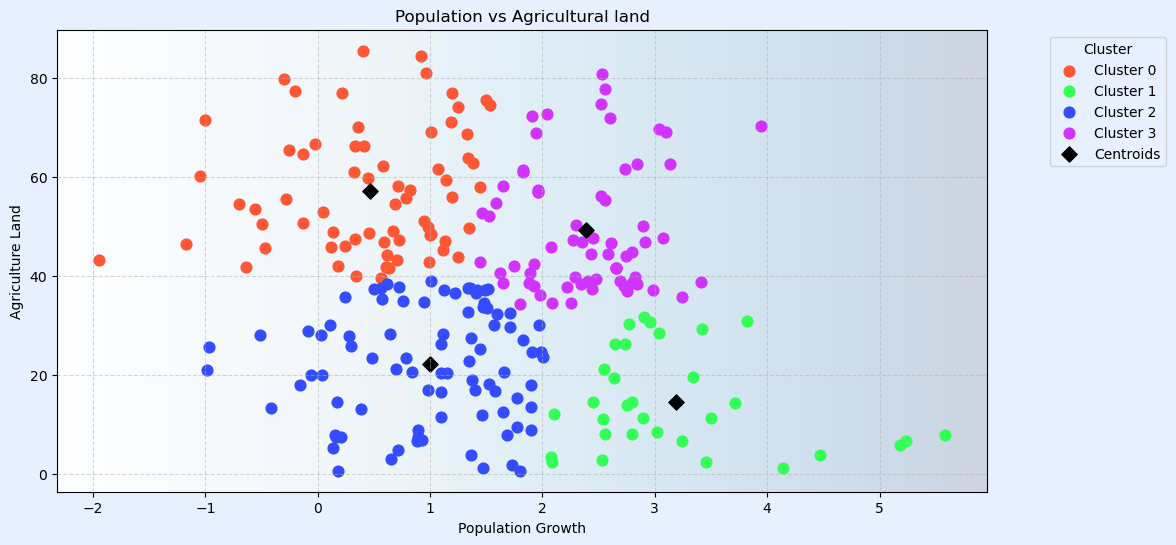

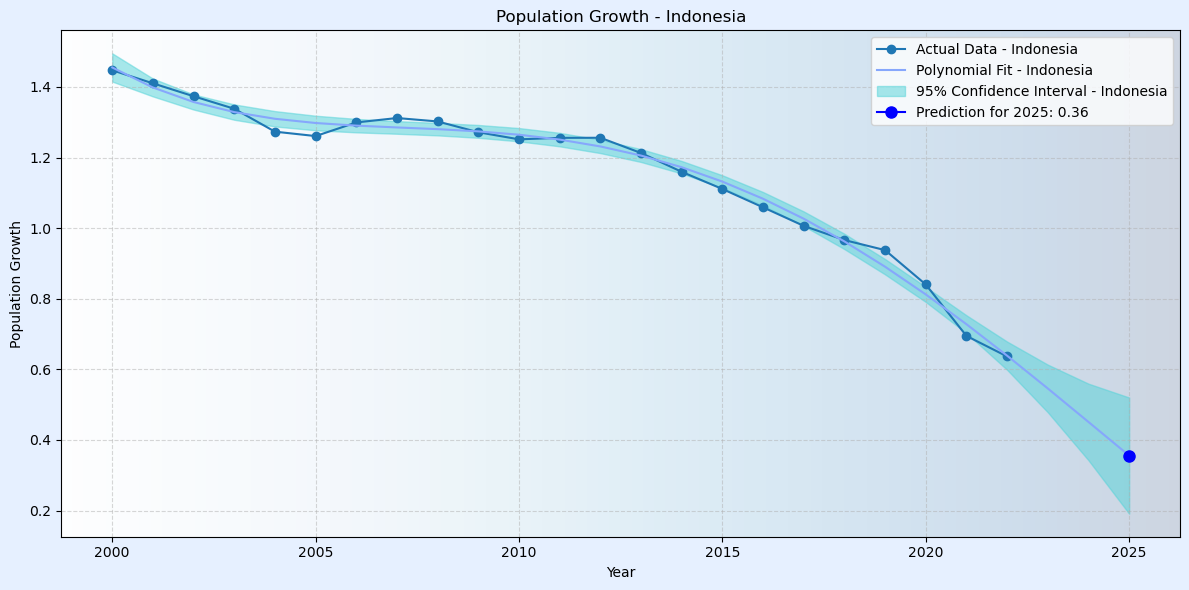

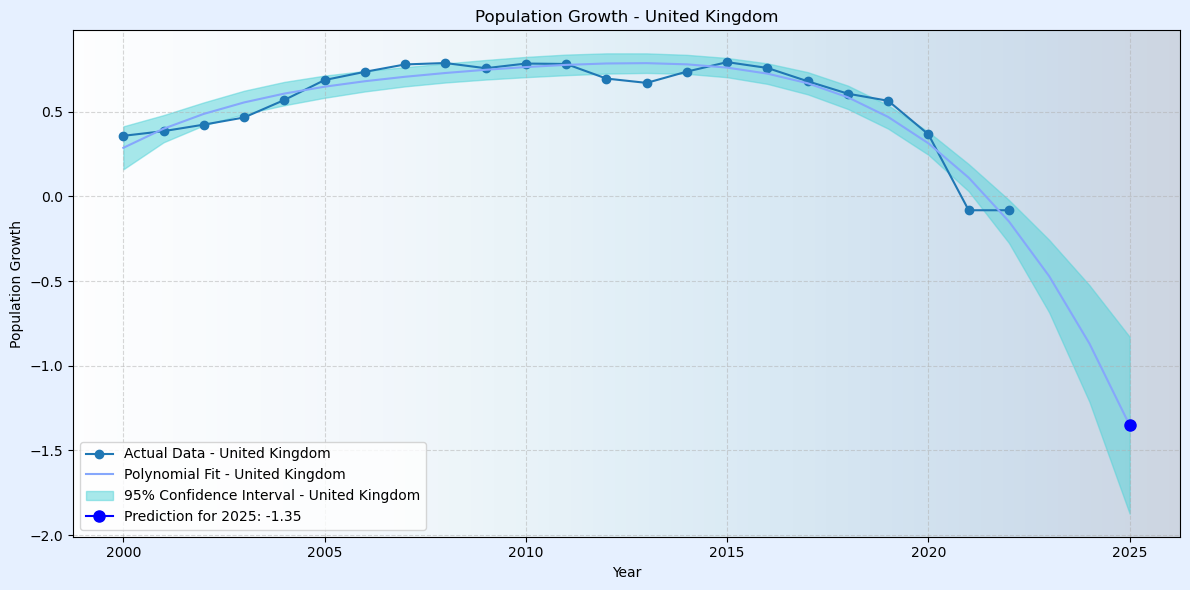

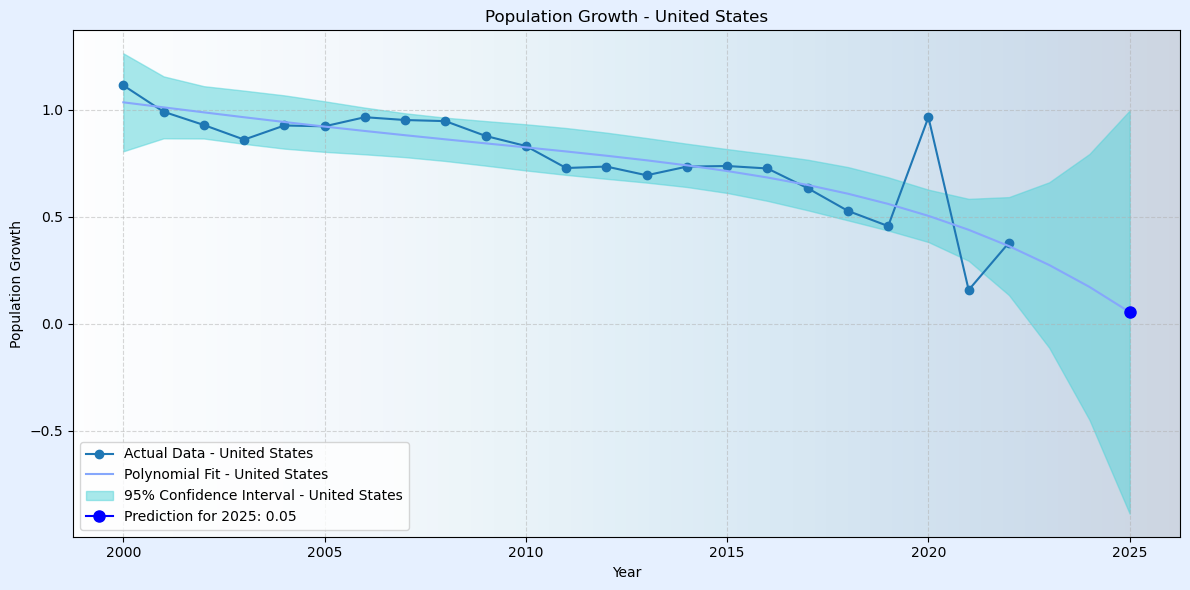

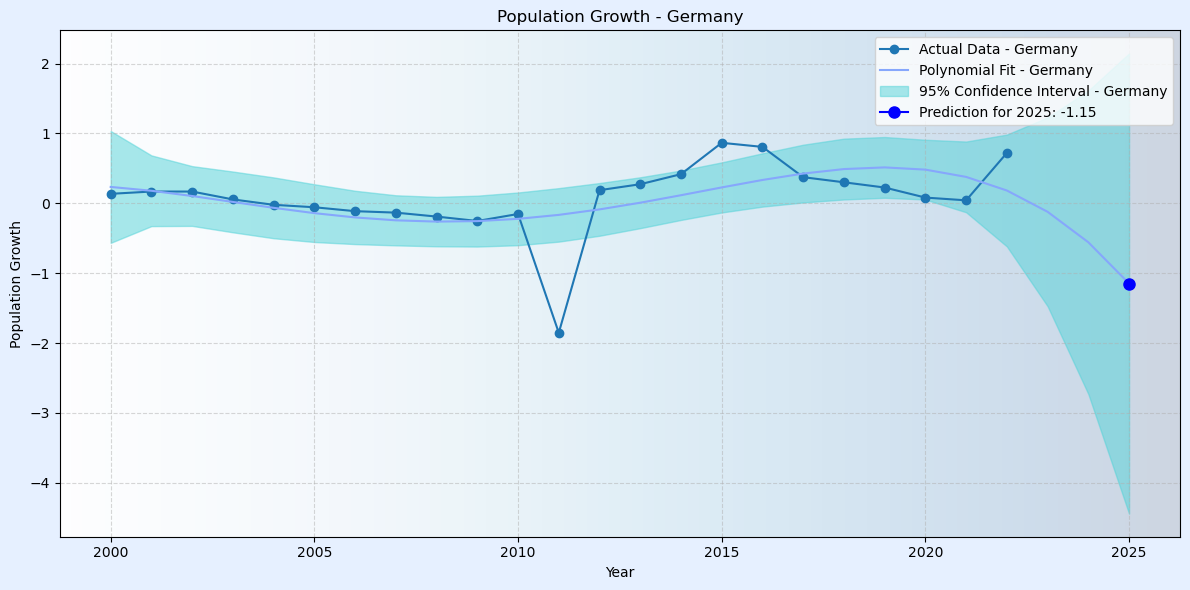

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import sklearn.cluster as cl
import os
import warnings
from sklearn.exceptions import ConvergenceWarning
import scipy.optimize as opt
import numpy as np
import sklearn.preprocessing as pp


def merge_indicators_new(file_path):
    """
    Merge specific indicators for the year 2000 from the transposed dataset.

    Parameters:
    - file_path (str): The path to the Excel file containing the dataset.

    Returns:
    - pd.DataFrame: Merged DataFrame with indicators for urban population growth and agricultural land in the year 2000.
    """
    # Read the new dataset
    data = pd.read_excel(file_path)

    # Transpose the data
    data_transposed = data.transpose()

    # Print first 2 rows of transposed data
    #print(data_transposed.head(2))
    
    #Print summary statistics of data
    data_statistics = data.describe()
    
    #Print summary statistics of transposed data
    #print(data_statistics.describe())

    # Filter out specific indicators for the year 2000
    urban_population = data[data["Indicator Name"] == "Population growth (annual %)"][["Country Name", 2000]]
    agriculture_land = data[data["Indicator Name"] == "Agricultural land (% of land area)"][["Country Name", 2000]]

    # Merge the two indicators on Country Name
    both = pd.merge(urban_population, agriculture_land, on="Country Name")

    # Rename columns
    both.columns = ["Country Name", "Population Growth", "Agriculture Land"]

    # Drop NaN values
    both = both.dropna()

    return both


def cluster_countries(data, selected_countries, selected_indicators):
    """
    Cluster selected countries based on specified indicators.

    Parameters:
    - data (pd.DataFrame): The input DataFrame containing the dataset.
    - selected_countries (list): List of country names to be included in the clustering.
    - selected_indicators (list): List of indicator names to be considered for clustering.

    Returns:
    - pd.DataFrame: DataFrame with clustered data, including the original indicators and the assigned clusters.
    - KMeans: Fitted KMeans model for further analysis.
    """
    filtered_data = data[
        (data["Country Name"].isin(selected_countries)) &
        (data["Indicator Name"].isin(selected_indicators))
    ]
    
    years_range = list(range(2010, 2021))
    filtered_data = filtered_data[["Country Name", "Indicator Name"] + years_range]

    data_melted = pd.melt(filtered_data, id_vars=["Country Name", "Indicator Name"], 
                          var_name="Year", value_name="Value")

    population_data = data_melted[data_melted["Indicator Name"] == "Population growth (annual %)"].drop('Indicator Name', axis=1)
    electricity_data = data_melted[data_melted["Indicator Name"] == "Agricultural land (% of land area)"].drop('Indicator Name', axis=1)

    population_data.rename(columns={"Value": "Population growth (annual %)"}, inplace=True)
    electricity_data.rename(columns={"Value": "Agricultural land (% of land area)"}, inplace=True)

    merged_data = pd.merge(population_data, electricity_data, on=["Country Name", "Year"])

    min_max_scaler = MinMaxScaler()
    normalized_data = merged_data.copy()
    normalized_data[["Population growth (annual %)", "Agricultural land (% of land area)"]] = min_max_scaler.fit_transform(merged_data[["Population growth (annual %)", "Agricultural land (% of land area)"]])

    # Suppressing warnings
    os.environ['OMP_NUM_THREADS'] = '1'
    # Suppress specific KMeans warning
    warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')
    
    kmeans = KMeans(n_clusters=5, random_state=0, n_init=10)
    kmeans.fit(normalized_data[['Population growth (annual %)', 'Agricultural land (% of land area)']])

    normalized_data['Cluster'] = kmeans.labels_

    return normalized_data, kmeans


def perform_clustering_new(data):
    """
    Perform clustering on normalized data and visualize the results.

    Parameters:
    - data (pd.DataFrame): Normalized DataFrame containing columns 'Population Growth' and 'Agriculture Land'.

    Returns:
    None, but saves a plot and an Excel file with clustered results.
    """

    # Normalize the data using a robust scaler
    scaler = pp.RobustScaler()
    to_clust = data[["Population Growth", "Agriculture Land"]]
    scaler.fit(to_clust)
    norm = scaler.transform(to_clust)

    # Set up the clustering function
    nclust = 4
    clusters = cl.KMeans(n_clusters=nclust, n_init=20)
    clusters.fit(norm)

    # Extract the labels and cluster centers
    labels = clusters.labels_
    centres = clusters.cluster_centers_
    centres = scaler.inverse_transform(centres)

    # Plotting
    cluster_shapes = ['o', 'o', 'o', 'o', 'o']
    cluster_colors = ['#FF5733', '#33FF57', '#334CFF', '#D133FF', '#FF5733']  # Different colors
    point_sizes = 60

    fig, ax = plt.subplots(figsize=(12, 6), facecolor='#E6F0FF')

    for cluster_label in range(nclust):
        cluster_data = data[labels == cluster_label]
        plt.scatter(cluster_data["Population Growth"], cluster_data["Agriculture Land"],
                    s=point_sizes, marker=cluster_shapes[cluster_label],
                    color=cluster_colors[cluster_label], label=f'Cluster {cluster_label}')

    plt.scatter(centres[:, 0], centres[:, 1], s=60, marker="D", color='k', label='Centroids')

    plt.xlabel("Population Growth")
    plt.ylabel("Agriculture Land")
    plt.title('Population vs Agricultural land')

    ax.grid(True, linestyle='--', alpha=0.5)
    ax.imshow(np.vstack([np.linspace(0, 1, 100)]*100), extent=[ax.get_xlim()[0], ax.get_xlim()[1], ax.get_ylim()[0], ax.get_ylim()[1]], origin='lower', aspect='auto', cmap=plt.get_cmap('Blues'), alpha=0.2)

    plt.legend(title='Cluster', loc='upper right', bbox_to_anchor=(1.2, 1), facecolor='#E6F0FF')

    plt.show()

    # Save the clustered data with labels
    data["Cluster"] = labels
    data.to_excel("C:\\Users\\User\\Downloads\\cluster_result-n.xlsx", index=False)
    
    
def reshape_data(data):
    """
    Reshape the input DataFrame by dropping the 'Indicator Name' column,
    setting 'Country Name' as the index, and transposing the data.

    Parameters:
    - data (pd.DataFrame): Input DataFrame with 'Country Name' and 'Indicator Name' columns.

    Returns:
    pd.DataFrame: Reshaped DataFrame with 'Country Name' as the index and transposed data.
    """
    data_reshaped = data.drop(['Indicator Name'], axis=1).set_index('Country Name').T
    data_reshaped.index = data_reshaped.index.astype(int)
    return data_reshaped


def polynomial_with_error(x, a, b, c, d, e):
    """
    Evaluate a polynomial function of degree 4 with the given coefficients.

    Parameters:
    - x (np.ndarray): Input values.
    - a, b, c, d, e (float): Coefficients of the polynomial function.

    Returns:
    np.ndarray: Result of the polynomial function evaluated at input values.
    """
    x = x - 2000
    return a + b * x + c * x**2 + d * x**3 + e * x**4


def confidence_interval(x, params, covar, func):
    """
    Calculate the confidence interval for a polynomial function.

    Parameters:
    - x (np.ndarray): Input values.
    - params (tuple): Coefficients of the polynomial function.
    - covar (np.ndarray): Covariance matrix of the polynomial function.
    - func (callable): Polynomial function.

    Returns:
    tuple: Lower and upper bounds of the confidence interval.
    """
        
    pred = func(x, *params)
    dfunc = [
        lambda x, a, b, c, d, e: 1,
        lambda x, a, b, c, d, e: (x - 2000),
        lambda x, a, b, c, d, e: (x - 2000)**2,
        lambda x, a, b, c, d, e: (x - 2000)**3,
        lambda x, a, b, c, d, e: (x - 2000)**4
                 ]
    J = np.array([[df(x, *params) for df in dfunc] for x in x])
    pred_se = np.sqrt(np.diag(J @ covar @ J.T))
    ci = 1.96 * pred_se
    return pred - ci, pred + ci


def plot_population_growth(data, sample_countries):
    """
    Plot population growth data for selected countries.

    Parameters:
    - data (pd.DataFrame): Input DataFrame with years as rows, countries as columns, and population growth data.
    - sample_countries (list): List of country names to plot.

    Returns:
    None
    """
    line_color = '#86A7FC'  # Different color
    fill_color = '#52D3D8'  # Different color
    interval_color = '#864AF9'  # Different color

    for i, country in enumerate(sample_countries, 1):
        if country in data.columns:
            country_data = data[country].dropna()
            param_poly, covar_poly = opt.curve_fit(
                polynomial_with_error, 
                country_data.index, 
                country_data.values,
                maxfev=10000
            )

            year_range = np.arange(2000, 2026)
            low_poly, up_poly = confidence_interval(year_range, param_poly, covar_poly, polynomial_with_error)

            prediction_2025 = polynomial_with_error(2025, *param_poly)

            # Set the face color for the entire main plot
            fig, ax = plt.subplots(figsize=(12, 6), facecolor='#E6F0FF')
            ax.grid(True, linestyle='--', alpha=0.5) and ax.imshow(np.vstack([np.linspace(0, 1, 100)]*100), extent=[ax.get_xlim()[0], ax.get_xlim()[1], ax.get_ylim()[0], ax.get_ylim()[1]], origin='lower', aspect='auto', cmap=plt.get_cmap('Blues'), alpha=0.2)

            plt.plot(country_data.index, country_data, label=f"Actual Data - {country}", marker="o")
            plt.plot(year_range, polynomial_with_error(year_range, *param_poly), label=f"Polynomial Fit - {country}", color=line_color)
            plt.fill_between(year_range, low_poly, up_poly, color=fill_color, alpha=0.5, label=f"95% Confidence Interval - {country}")
            plt.plot(2025, prediction_2025, marker='o', markersize=8, label=f'Prediction for 2025: {prediction_2025:.2f}', color='blue')
            plt.title(f"Population Growth - {country}")
            plt.xlabel("Year")
            plt.ylabel("Population Growth")
            plt.legend()
            ax.imshow(np.vstack([np.linspace(0, 1, 100)]*100), extent=[ax.get_xlim()[0], ax.get_xlim()[1], ax.get_ylim()[0], ax.get_ylim()[1]], origin='lower', aspect='auto', cmap=plt.get_cmap('Blues'), alpha=0.2)
            plt.tight_layout()
            plt.show()
         
        
def main():
    """
    The main function to execute the entire data processing and visualization workflow.

    1. Read the new dataset and merge indicators.
    2. Select countries and indicators for clustering.
    3. Perform clustering on the original dataset.
    4. Plot population growth for selected countries.
    Returns:
    None
    """

    # Path to the input file
    file_path = "world_bank_data_New.xlsx"

    # Step 1: Read the new dataset and merge indicators
    data = merge_indicators_new(file_path)

    # Step 2: Select countries and indicators for clustering
    selected_countries = ["Germany", "United Kingdom", "Indonesia", "United States"]
    selected_indicators = [
        "Population growth (annual %)",
        "Agricultural land (% of land area)"
    ]

    # Step 3: Perform clustering on the original dataset
    original_data = pd.read_excel(file_path)
    normalized_data, kmeans = cluster_countries(original_data, selected_countries, selected_indicators)
    
    # Call perform_clustering_new with the merged data
    perform_clustering_new(data)

    # Step 4: Plot population growth for selected countries
    population_growth_data = original_data[original_data['Indicator Name'] == 'Population growth (annual %)']
    population_growth_reshaped = reshape_data(population_growth_data)

    sample_countries = ["Indonesia", "United Kingdom", 'United States', "Germany"]
    plot_population_growth(population_growth_reshaped, sample_countries)

# Execute the main function
main()
